In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

In [2]:
BATCH_SIZE = 16

DATASET_DIR = "/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/tampered_dataset_small_wav"

In [3]:
def tamper_type(filename):
    file_split = filename[:-4].split("_")[-1]
    # print(file_split)
    return file_split

test_file ="Audio_01_00018_330s_to_360s_insert.mp3"
tamper_type(test_file)

'insert'

In [4]:
def extract_features(file_path):
    signal, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    return np.array([mfccs, delta_mfccs, delta2_mfccs])

In [5]:
features = []
labels = []

# Extract features from dataset
for filename in os.listdir(DATASET_DIR):
    if filename.endswith('.wav'):
        file_path = os.path.join(DATASET_DIR, filename)
        try:
            type_file = tamper_type(filename)
            # print(labels)
            feature = extract_features(file_path)
            features.append(feature)
            # print(filename)

            if type_file == "insert":
                labels.append(0)
            elif type_file == "del":
                labels.append(1)
            elif type_file == "replace":
                labels.append(2)
            else:
                labels.append(3)
        except:
            pass

len(features), len(labels), type(features)

(800, 800, list)

In [6]:
type(features[0])

numpy.ndarray

In [7]:
class ENFDataset(Dataset):
    """Dataset class for ENF features"""
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.FloatTensor([self.labels[idx]])
        return feature, label

In [8]:
def prepare_dataloader(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    train_dataset = ENFDataset(X_train, y_train)
    val_dataset = ENFDataset(X_val, y_val)
    test_dataset = ENFDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return train_loader, val_loader, test_loader, X_test, y_test
    

In [9]:
features[0][0].shape, features[0][1].shape, features[0][2].shape 

((13, 431), (13, 431), (13, 431))

In [10]:
train_loader_1, val_loader_1, test_loader_1, X_test, y_test = prepare_dataloader(features, labels)

In [11]:
len(X_test), len(y_test)

(160, 160)

In [12]:
for file_path in os.listdir(DATASET_DIR):
    file_path = os.path.join(DATASET_DIR, file_path)
    break

_, sr = librosa.load(file_path)
sr

22050

In [13]:
fe = features[45]
fe_mfccs = fe[0]
fe_delta_mfccs = fe[1]
fe_delta2_mfccs = fe[2]
labels[45]

3

In [14]:
fe_mfccs.shape, fe_delta_mfccs.shape, fe_delta2_mfccs.shape

((13, 431), (13, 431), (13, 431))

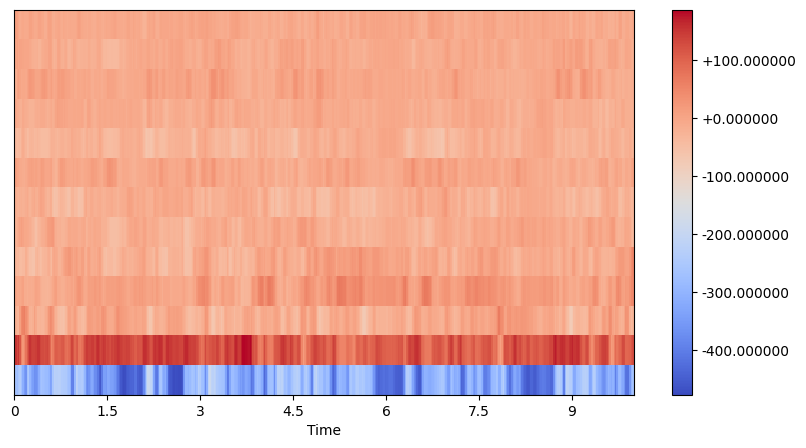

In [15]:
# visualizing mfccs
fe_mfccs_npy = fe_mfccs

plt.figure(figsize=(10,5))
librosa.display.specshow(
    fe_mfccs_npy, x_axis="time", sr=sr
)
plt.colorbar(format="%+2f")
plt.show()

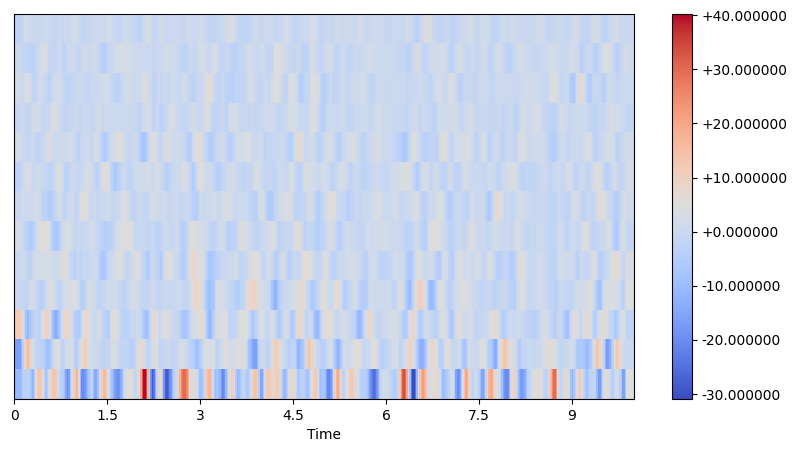

In [16]:
# visualizing delta mfccs
plt.figure(figsize=(10,5))
librosa.display.specshow(
    fe_delta_mfccs, x_axis="time", sr=sr
)
plt.colorbar(format="%+2f")
plt.show()

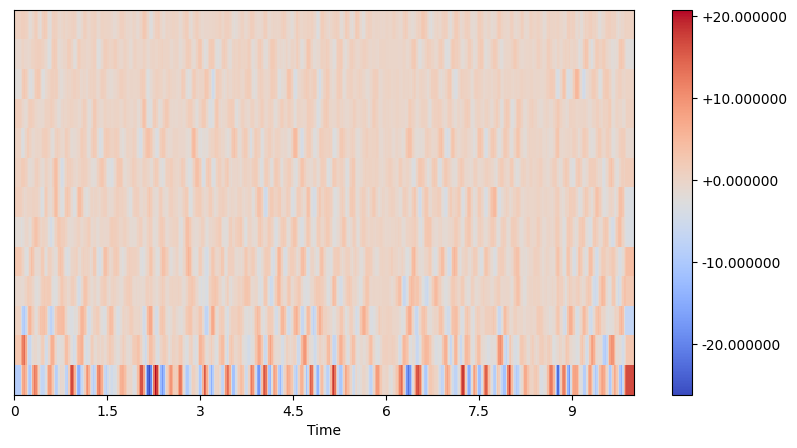

In [17]:
# visualizing delta 2 mfccs
plt.figure(figsize=(10,5))
librosa.display.specshow(
    fe_delta2_mfccs, x_axis="time", sr=sr
)
plt.colorbar(format="%+2f")
plt.show()

In [18]:
for fe, _ in train_loader_1:
    print(fe.shape)
    break

torch.Size([16, 3, 13, 431])


## Model

In [19]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        self.c1 =  nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
        )
        self.f1 = nn.Flatten()
        self.d1 = nn.Sequential(
            nn.Linear(7,36),
             nn.Linear(36,36),
            nn.Linear(36,4),
        )
        self.o1 = nn.Softmax()
    
    def forward(self, x):
        x1 =  self.c1(x)
        x2 = self.f1(x1)
        x3 = self.d1(x2)
        x4 = self.o1(x3)

        return x4



In [20]:
model = CNNNetwork()
x = torch.randn(4, 3, 13, 431)
out = model(x)
out.shape, out

/opt/miniconda3/envs/envTorch/lib/python3.11/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(torch.Size([4, 4]),
 tensor([[0.2182, 0.2289, 0.3084, 0.2445],
         [0.2293, 0.2285, 0.3052, 0.2370],
         [0.2393, 0.2311, 0.2900, 0.2396],
         [0.2319, 0.2395, 0.2765, 0.2521]], grad_fn=<SoftmaxBackward0>))

In [21]:
summary(model=model, input=(1,3,13,431))

Layer (type:depth-idx)                   Param #
CNNNetwork                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       432
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       4,096
│    └─BatchNorm2d: 2-5                  32
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       8,192
│    └─BatchNorm2d: 2-8                  64
│    └─ReLU: 2-9                         --
│    └─Conv2d: 2-10                      18,432
│    └─BatchNorm2d: 2-11                 128
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      73,728
│    └─BatchNorm2d: 2-14                 256
│    └─ReLU: 2-15                        --
│    └─Conv2d: 2-16                      294,912
│    └─BatchNorm2d: 2-17                 512
│    └─ReLU: 2-18                        --
│    └─Conv2d: 2-19                      1,179,6

In [22]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
import csv
# loss_g: 3.5279, loss_d: 0.6153, real_score: 0.7169, fake_score: 0.1814
titles = ["epoch", "train_accuracy", "train_loss", "val_loss", "val_accuracy"]

with open("record1.csv", 'w') as cf:
    csvwriter = csv.writer(cf)
    # writing the fields
    csvwriter.writerow(titles)
    # writing the data rows
cf.close()

In [24]:
def record_data(data, file='record1.csv'):

    with open(file, 'a') as cf:
        writer_object = csv.writer(cf)
        writer_object.writerow(data)
 
    # Close the file object
    cf.close()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model_multiclass(model, train_loader, val_loader, epochs=50, lr=0.001, file="record1.csv", model_path="trained_model1.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()  # Multiclass classification loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    best_model = None
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)  # Move to GPU/CPU

            optimizer.zero_grad()
            outputs = model(features)  # Logits: [batch_size, num_classes]
            
            # Ensure labels are of type `long` and shape `[batch_size]`
            labels = labels.squeeze().long()
            
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects raw logits and class indices
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * features.size(0)
            preds_train = torch.argmax(outputs, dim=1)  # Get predicted class indices
            correct_train += (preds_train == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                labels = labels.squeeze().long()  # Ensure proper label shape
                
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)  # Get predicted class indices
                correct += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        print(f'Epoch {epoch+1}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        record_data([epoch+1, train_acc, train_loss, val_loss, val_acc], file=file)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_model)

    # Save the model
    torch.save(model.state_dict(), model_path)

    return train_accs, train_losses, val_losses, val_accs


In [27]:
epochs = 100
lr = 0.001

In [28]:
# Model Training
history1 = train_model_multiclass(model, train_loader_1, val_loader_1, epochs=epochs, lr=lr, file="record1.csv", model_path='trained_model1.pth')
print("Done")

/opt/miniconda3/envs/envTorch/lib/python3.11/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Train Acc: 0.4375, Train Loss: 1.2994, Val Loss: 1.1882, Val Acc: 0.4609
Epoch 2, Train Acc: 0.4512, Train Loss: 1.2390, Val Loss: 1.2327, Val Acc: 0.4062
Epoch 3, Train Acc: 0.4688, Train Loss: 1.2322, Val Loss: 1.2214, Val Acc: 0.4141
Epoch 4, Train Acc: 0.4609, Train Loss: 1.2154, Val Loss: 1.1938, Val Acc: 0.4453
Epoch 5, Train Acc: 0.4766, Train Loss: 1.2091, Val Loss: 1.1757, Val Acc: 0.4609
Epoch 6, Train Acc: 0.4473, Train Loss: 1.2091, Val Loss: 1.1730, Val Acc: 0.4609
Epoch 7, Train Acc: 0.4219, Train Loss: 1.2093, Val Loss: 1.1748, Val Acc: 0.4609
Epoch 8, Train Acc: 0.4727, Train Loss: 1.2109, Val Loss: 1.1750, Val Acc: 0.4609
Epoch 9, Train Acc: 0.4629, Train Loss: 1.2198, Val Loss: 1.1741, Val Acc: 0.4609
Epoch 10, Train Acc: 0.4648, Train Loss: 1.2178, Val Loss: 1.1907, Val Acc: 0.5312
Epoch 11, Train Acc: 0.4395, Train Loss: 1.2180, Val Loss: 1.2414, Val Acc: 0.5000
Epoch 12, Train Acc: 0.4668, Train Loss: 1.2153, Val Loss: 1.1717, Val Acc: 0.5234
Epoch 13, Tra

In [29]:
torch.save(model.state_dict(),"final_model1.pth")

In [30]:
train_accuracy, training_losses, val_losses, val_accuracy = history1

In [31]:
len(train_accuracy), len(training_losses), len(val_losses), len(val_accuracy)

(100, 100, 100, 100)

In [ ]:
# Plot Generator and Discriminator Loss
plt.plot(training_losses, '-')
plt.plot(val_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(["training_losses", "val_losses"])
plt.title('Model Losses')

In [ ]:
# Plot Real and Fake score
plt.plot(train_accuracy, '-')
plt.plot(val_accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Train Accuracy', "Val Accuracy"])
plt.title('Scores')
plt.show()